In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from KCrossVal import kFoldCross, MeanAbsError, BinaryAccuracy
import time
from sklearn.decomposition import PCA


In [10]:
dataset_df = pd.read_csv('./data/Financial_Data.csv')
dataset_df = dataset_df.sample(frac=1)
excluded_cols = ['Stock', 'Sector', 'Class', 'Year', 'PRICE VAR [%]']
num_cols = [c for c in dataset_df.columns if c not in excluded_cols]
X_dev = dataset_df[num_cols].to_numpy()
Y_float = dataset_df['PRICE VAR [%]'].to_numpy()
Y_bin = dataset_df['Class'].to_numpy()

N of rows = 19500
Dropping rows where PRICE VAR [%] > 150 = 363


Text(0.5, 1.0, 'PRICE VAR [%] distribution (up to 150%)')

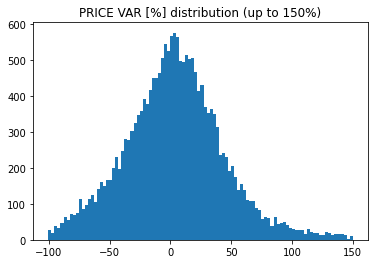

In [3]:
print('N of rows =',len(X_dev))
print('Dropping rows where PRICE VAR [%] > 150 =',np.sum((Y_float>150).astype(int)))

to_keep = Y_float < 150

Y_float = Y_float[to_keep]
Y_bin = Y_bin[to_keep]
X_dev = X_dev[to_keep]

plt.hist(Y_float,bins=100)
plt.title('PRICE VAR [%] distribution (up to 150%)')

# Dim reduction
# pca = PCA(.95)
# X_dev = pca.fit_transform(X_dev)

N of rows = 19500
Dropping rows where PRICE VAR [%] > 500 = 45


Text(0.5, 1.0, 'PRICE VAR [%] distribution (up to 500%)')

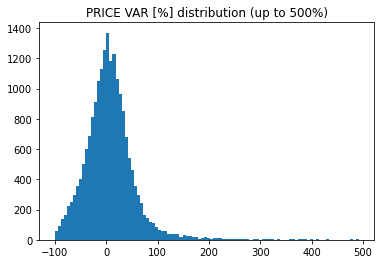

In [15]:
print('N of rows =',len(X_dev))
print('Dropping rows where PRICE VAR [%] > 500 =',np.sum((Y_float>500).astype(int)))

to_keep = Y_float < 500

Y_float = Y_float[to_keep]
Y_bin = Y_bin[to_keep]
X_dev = X_dev[to_keep]

plt.hist(Y_float,bins=100)
plt.title('PRICE VAR [%] distribution (up to 500%)')

# Dim reduction
# pca = PCA(.95)
# X_dev = pca.fit_transform(X_dev)

In [27]:
# Logistic Regression
# HP tuning with k-cross validation
C_values = [0.1,1,2]
results = []
for C in C_values:
    reg = linear_model.LogisticRegression(C=C,max_iter=1000)
    res = kFoldCross(reg.fit, reg.predict, X_dev, Y_bin, 5, MeanAbsError)
    res = C, res[0], res[1], res[3]
    results.append(res)

df = pd.DataFrame(results, columns=['C', 'ValErr_mean', 'ValErr_std', 'seconds'])
df.sort_values(by='ValErr_mean')

,C,ValErr_mean,ValErr_std,seconds
2,2.0,0.394523,0.007774,108.574087
1,1.0,0.395778,0.007128,84.585056
0,0.1,0.397032,0.008153,34.514192


In [36]:
# Linear Regression
# HP tuning with k-cross validation
# error is measured with output made binary: out = 0 if out<0, else out=1

alpha = [1e2,1e3,1e4]
results = []
for a in alpha:
    reg = linear_model.Ridge(alpha=a)
    res = kFoldCross(reg.fit, reg.predict, X_dev, Y_float, 5, MeanAbsError)
    res = a, res[0], res[1], res[3]
    results.append(res)

df = pd.DataFrame(results, columns=['alpha', 'ValErr_mean', 'ValErr_std', 'seconds'])
df.sort_values(by='ValErr_mean')

,alpha,ValErr_mean,ValErr_std,seconds
1,1000.0,30.575833,0.243612,2.293634
2,10000.0,30.585902,0.264006,2.300055
0,100.0,30.841726,0.269901,2.095049


In [7]:
from sklearn.neural_network import MLPRegressor
import itertools

# Neural Network model
# HP tuning with k-cross validation
layers_list = [(20,20),(15,15)]
alpha_list = [0.0001,0.001,0.00001]
HP_list = itertools.product(layers_list, alpha_list)
results = []
for layers, alpha in HP_list:
    reg = MLPRegressor(random_state=1, hidden_layer_sizes=layers,alpha=alpha,max_iter=2000,early_stopping=True)
    res = kFoldCross(reg.fit, reg.predict, X_dev, Y_float, 5, MeanAbsError)
    res = layers, alpha, res[0], res[1], res[3]
    results.append(res)

df = pd.DataFrame(results, columns=['Hidden_layers', 'L2 Reg','ValErr_mean', 'ValErr_std', 'seconds'])
df.sort_values(by='ValErr_mean')

,Hidden_layers,L2 Reg,ValErr_mean,ValErr_std,seconds
3,"(15, 15)",0.00010,30.390355,0.406341,53.463302
2,"(20, 20)",0.00001,30.397160,0.496040,53.646423
1,"(20, 20)",0.00100,30.397170,0.496554,53.717658
0,"(20, 20)",0.00010,30.397418,0.496614,51.950745
5,"(15, 15)",0.00001,30.412148,0.401158,56.894262
4,"(15, 15)",0.00100,30.412305,0.402976,55.055161


In [24]:
corr_values = []
for c in num_cols:
    array = dataset_df[c]
    corr = np.corrcoef(array, Y_float)[0,1]
    corr_values.append((corr, c))

corr_values.sort(key= lambda tup: -np.abs(tup[0]))
print('top correlated columns to Y_float')
corr_values[:3]

top correlated columns to Y_float


[(0.0787488753412246, 'shortTermCoverageRatios'),
 (0.07825967239043417, 'payoutRatio'),
 (0.06500862906163313, 'Interest Debt per Share')]